<a href="https://colab.research.google.com/github/SilverSurferClash/Sales_analysis/blob/main/Import_clean_SFDC_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [460]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [461]:
#!pip freeze > requirements.txt

In [462]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
import os
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 2)
#Use option to round floats to two decimals
#pd.set_option('display.float_format',  '{:,.2f}'.format)
# Use option to display $ dollars
#pd.set_option('display.float_format', '${:.2f}'.format)

# Plotting pretty figures and avoid blurry images
#%config InlineBackend.figure_format = 'retina'
# Larger scale for plots in notebooks
#sns.set_context('notebook')


# Enable multiple cell outputs
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.filterwarnings('ignore')              


In [463]:
os.getcwd()

'/content/drive/My Drive/Colab_Notebooks/Sales_Analysis'

In [464]:
os.chdir("/content/drive/MyDrive/Colab_Notebooks/Sales_Analysis")

#### Helper function

In [465]:
#Create a function that use the second element if the list has a length of 2 other return unknown

def clean_up_account(list_of_names):

  if len(list_of_names) == 2:
    return list_of_names[1]
  else:
    return list_of_names[0]


In [466]:
#Create a function to clean up the Billing type feature


Import helper data

In [467]:
#Import lookup table for countries
lookup_countries = pd.read_excel("./lookup.xlsx", sheet_name = 0)
#Import the data from SFDC as a excel file
import_sfdc = pd.read_excel("./All Data EUAA-2022-10-25-12-29-00.xlsx", sheet_name = 0, 
                            skiprows = 10)
#Create dictionairy for maping the lookup value
country_dict = dict(zip(lookup_countries["Reporting_Country_short"], lookup_countries["Account_Reporting_Country"]))
#Import lookup table for countries
lookup_type = pd.read_excel("./lookup.xlsx", sheet_name = "Type")
#Create dictionairy for maping the lookup values for LIMS ID
type_dict = dict(zip(lookup_type["LIMS Project ID"], lookup_type["Type"]))

#Import lookup Cancer Type
lookup_cancer_type = pd.read_excel("./lookup.xlsx", sheet_name = "Cancer_type")
cancer_type_dict = dict(zip(lookup_cancer_type["Old"], lookup_cancer_type["New"]))

#Inport lookun Billing_type - Needs further work
#lookup_billing_type = pd.read_excel("./lookup.xlsx", sheet_name = "Billing_type")
#billing_type_dict = dict(zip(lookup_billing_type["Billing Type"], lookup_billing_type["Billing Type.1"]))


In [468]:
#Identify which LIMS id are not in the lookup
unique_LIMS_id = list(set(import_sfdc["LIMS Project ID"]))
unique_lookup_id = list(set(lookup_type["LIMS Project ID"]))
list(set(unique_LIMS_id) - set(unique_lookup_id ))

[nan, 'GAP_04', 'OCT_1R', 'AZN_test_96', 'JNS_01', 'GAP_09', 'RHI_04']

In [469]:
#import_sfdc.info()

#### Import and clean up the data from SFDC

In [470]:

#Remove the first two columns
import_sfdc = import_sfdc.drop(["Unnamed: 0", "Unnamed: 2"], axis = 1)
#Drop the last five rows
import_sfdc = import_sfdc.iloc[0:-5]
#Cast Date Received to datetime object 
import_sfdc["Date Received"] = pd.to_datetime(import_sfdc["Date Received"])
#Clean up the type column
import_sfdc["Type"] = import_sfdc["LIMS Project ID"].map(type_dict)

#Replace the two letter country code with the full country name
import_sfdc["Reporting Country"] = import_sfdc["Reporting Country"].map(country_dict)
#Clean up the cancer types and reduce number of categories
import_sfdc["Cancer Type"] = import_sfdc["Cancer Type"].map(cancer_type_dict)
#Clean up the Account column by removing all strings before the ":"
import_sfdc["Account: Account Name"] = import_sfdc.loc[:, "Account: Account Name"].str.split(":").apply(clean_up_account)
#Clean up the Billing type column 
#import_sfdc["Billing Type"] = import_sfdc["Billing Type"].map(billing_type_dict)
#import_sfdc.tail(6)

# Set the date recieved as date index
import_sfdc = import_sfdc.set_index("Date Received")

#import_sfdc.info()

In [471]:
import_sfdc["LIMS Project ID"]

Date Received
2019-11-25    AMG_01
2019-11-26    AMG_01
2019-11-29    AMG_01
2019-11-30    AMG_01
2019-11-30    AMG_01
               ...  
2021-01-04    VLT_01
2021-01-11    VLT_01
2021-01-11    VLT_01
2021-01-15    VLT_01
2021-01-20    VLT_01
Name: LIMS Project ID, Length: 14977, dtype: object

In [472]:
#Create date and time features

#Create a year, month, quarter variable
import_sfdc["Month"] = import_sfdc.index.month
import_sfdc["Year"] = import_sfdc.index.year
import_sfdc['Quarter'] = import_sfdc.index.quarter
#Other feature engineering based on feature analysis below
import_sfdc['Sales'] = 1

#create a Year Month columns
import_sfdc['Year_Month'] = import_sfdc.index.to_period('M')
#Cast the Year_Month column to a str
import_sfdc['Year_Month'] = import_sfdc['Year_Month'].astype(str)
import_sfdc['Year_Month'] = pd.to_datetime(import_sfdc['Year_Month'])
#Cast some features to categorical
#df['Reporting_Country'] = df['Reporting_Country'].astype('category')
import_sfdc['Type'] = import_sfdc['Type'].astype('category')


In [473]:
#import_sfdc.sample(5)

#### Explore the data

In [474]:
#import_sfdc["Reporting Country"].value_counts()

In [475]:
#import_sfdc.Type.value_counts()

In [476]:
#import_sfdc.info()

In [477]:
#import_sfdc["Billing Type"].value_counts()

In [478]:
#import_sfdc["Test Type"].value_counts()

In [479]:
#import_sfdc["Cancer Type"].value_counts()

In [480]:
#import_sfdc['Billing Type'].value_counts()

In [481]:
# Import the revenue data

revenue_import = pd.read_excel("./Sales_Volume_EUAA_Analytics.xlsx", skiprows = 28)
revenue_import = revenue_import.iloc[:, 1:12]
#revenue_import.columns.tolist()
revenue_import['Accession #']= revenue_import['Accession #'].fillna("missing") 
revenue_import = revenue_import[revenue_import['Accession #'].str.startswith("A0")]
#revenue_import.info()

In [482]:
#revenue_import.columns.tolist()

In [483]:
revenue_col_list = ['Accession #', 'Invoiced Ammount','Expected Amount $','Invoiced/In Prg.', 'FOC']

In [484]:
#Define the clean up function for the FOC columns
def foc_clean_up(value):

  if value == "x":
    return "Free"

  elif value == "x (COV19)":
     return "Free"
  elif value == "x (Christie)":
    return "Free"
  else: 
    return value

#Clean up Docuten

def docuten_clean_up(value):

  if value == "y (DOCUTEN)":
    return "Free"

  else: 
    return value

#Clean up the revenue data and extract the free of charge information
revenue_import_clean = revenue_import.loc[:, revenue_col_list].copy()
revenue_import_clean["FOC"] = revenue_import_clean["FOC"].fillna("Paid")
revenue_import_clean.head()

,Accession #,Invoiced Ammount,Expected Amount $,Invoiced/In Prg.,FOC
0,A0198807,0.0,0.0,NaN,x
1,A0196311,0.0,0.0,NaN,x
3,A0196102,3490.0,3490.0,NaN,Paid
4,A0195058,3490.0,3490.0,NaN,Paid
6,A0196290,3490.0,3490.0,NaN,Paid


In [485]:
#revenue_import_clean["FOC"].value_counts()

In [486]:
revenue_import_clean["FOC"] = revenue_import_clean["FOC"].apply(foc_clean_up).astype("category")

In [487]:
revenue_import_clean["FOC"].value_counts()

Paid    2944
Free     715
           1
Name: FOC, dtype: int64

In [488]:
#Join the two dataframes

df_merged = import_sfdc.merge(revenue_import_clean[["Accession #", "FOC"]], how='inner', on = "Accession #")
df_merged.sample(3)

,Accession #,Reporting Country,Billing Type,LIMS Project ID,Account: Account Name,Contact: Full Name,Final Report Date,Test Type,Cancer Type,Type,Month,Year,Quarter,Sales,Year_Month,FOC
1765,A0370195,UNITED KINGDOM,Self-Pay Patient,GHI_01,The Nuffield Hospital Guildford,Tony Dhillon,7/3/2021,Guardant 360,GI,Commercial,6,2021,2,1,2021-06-01,Paid
2482,A0459705,UNITED KINGDOM,Self-Pay Patient,GHI_01,Southampton General Hospital,Almurtadha Mula-Kh,2/1/2022,Guardant 360,GI,Commercial,1,2022,1,1,2022-01-01,Free
1917,A0388822,BRAZIL,Distributors : ROW,GHI_01,Diagnosticos da America S.A.,Cristovam Scapulatempo Neto,8/22/2021,Guardant 360,NaN,Commercial,8,2021,3,1,2021-08-01,Paid


In [489]:
# Startinf dataframe for all years
#import_sfdc.info()

In [490]:
#Cleaned up dataframe included FOC information starting from around 2019
#df_merged.info()

#### Plotting

In [491]:
#Select the features for the analysis
import_sfdc.columns.to_list()
list_for_country_analysis = ['Accession #',
 'Reporting Country',
 'Type',
 'Sales',
 'Year_Month']

countries_df = import_sfdc.loc[:,list_for_country_analysis ]
#countries_df["Reporting Country"] = countries_df["Reporting Country"].astype('category')
countries_df.sample(3)

,Accession #,Reporting Country,Type,Sales,Year_Month
Date Received,,,,,
2021-08-30,A0392927,UNITED KINGDOM,Commercial,1,2021-08-01
2021-03-30,A0342217,UNITED KINGDOM,Commercial,1,2021-03-01
2022-04-27,A0505191,BRAZIL,Commercial,1,2022-04-01


In [492]:
#Starting df for plotting
countries_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14977 entries, 2019-11-25 to 2021-01-20
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Accession #        14977 non-null  object        
 1   Reporting Country  14977 non-null  object        
 2   Type               14873 non-null  category      
 3   Sales              14977 non-null  int64         
 4   Year_Month         14977 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](1), int64(1), object(2)
memory usage: 599.9+ KB


In [493]:
#Plot the total number of by country over time

In [494]:
#Select the time horizion to analyse
start_date = "2018"
end_date = "2022-09"
#Select the # of countries to be analyses based on the maxiumum number of samplesin 
#the time horizon
num_countries = 6
#Create the dataframe relevant for the time periode which should be analysed
countries_df = countries_df.loc[start_date:end_date].copy()
print(f"The total number of samples in this dataframe is {countries_df.shape[0]}")

The total number of samples in this dataframe is 14977


In [495]:
#Create a dataframe with just the topx countries by number of tests sold
top_x = countries_df.groupby('Reporting Country').sum().sort_values("Sales",ascending = False).head(num_countries)
top_x_list = top_x.index.tolist()
top_x_sales =countries_df[countries_df['Reporting Country'].isin(top_x_list)]
print(f"The top {num_countries} countries have {top_x_sales.shape[0]} samples which represents {top_x_sales.shape[0]/countries_df.shape[0]:.2%}")

The top 6 countries have 12243 samples which represents 81.75%


In [496]:
#Starting dataframe for plotting with date defined and the number of countries
#top_x_sales.info()

In [497]:
#Merging the GH trials and LUNAR into ISTs

def merge_ISTs(x):
  if x == "GH Trials (Prospective)":
    return "ISTs"
  elif x == "Lunar":
    return "ISTs"
  else:
    return x

In [498]:
top_x_sales["Type"] = top_x_sales["Type"].map(merge_ISTs)

top_x_sales["Type"].value_counts()

Biopharma     4485
Commercial    3071
ISTs          2811
GAP           1778
Name: Type, dtype: int64

In [499]:
all_countries_by_type = top_x_sales.groupby(['Year_Month', "Type"]).sum().reset_index()
all_countries_by_type.head(3)

,Year_Month,Type,Sales
0,2019-01-01,Biopharma,105
1,2019-01-01,Commercial,26
2,2019-01-01,ISTs,76


In [500]:
all_countries_by_type.shape

(173, 3)

In [501]:
#Use relpot for plotting

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

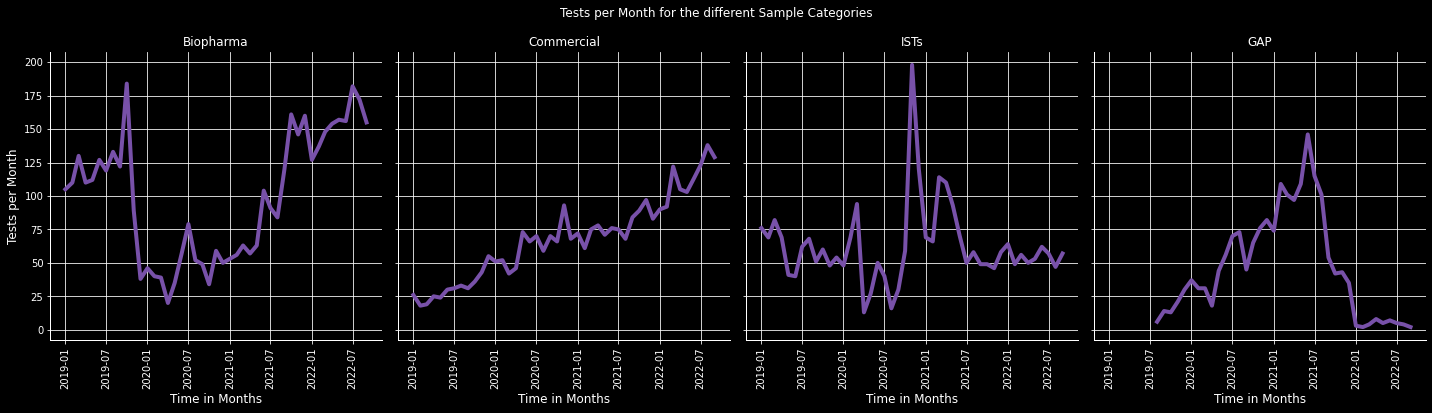

In [502]:
#Plot the sales for each category over time
g = sns.relplot(data = all_countries_by_type, x = "Year_Month", y = "Sales", kind = "line", col = "Type", color = "#7851a9", linewidth=4 )
g.set_xticklabels(rotation = "90")

g.set_ylabels("Tests per Month")
g.set_xlabels("Time in Months")
g.set_titles(col_template = '{col_name}')
g.fig.suptitle('Tests per Month for the different Sample Categories', y=1.05)

plt.savefig('facet_plot.pdf', dpi = 300, bbox_inches ="tight",
            pad_inches = 1)
files.download("facet_plot.pdf")
plt.show()


In [503]:
#Re-create the stacked area plot used so far


#Create a df in the wide format with the type category providing the new column labels

all_countries_pivot_type = all_countries_by_type.pivot(index = "Year_Month", columns = "Type", values = "Sales")
all_countries_pivot_type.head()


Type,Biopharma,Commercial,GAP,ISTs
Year_Month,,,,
2019-01-01,105.0,26.0,NaN,76.0
2019-02-01,110.0,18.0,NaN,69.0
2019-03-01,130.0,19.0,NaN,82.0
2019-04-01,110.0,25.0,NaN,69.0
2019-05-01,112.0,24.0,NaN,41.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

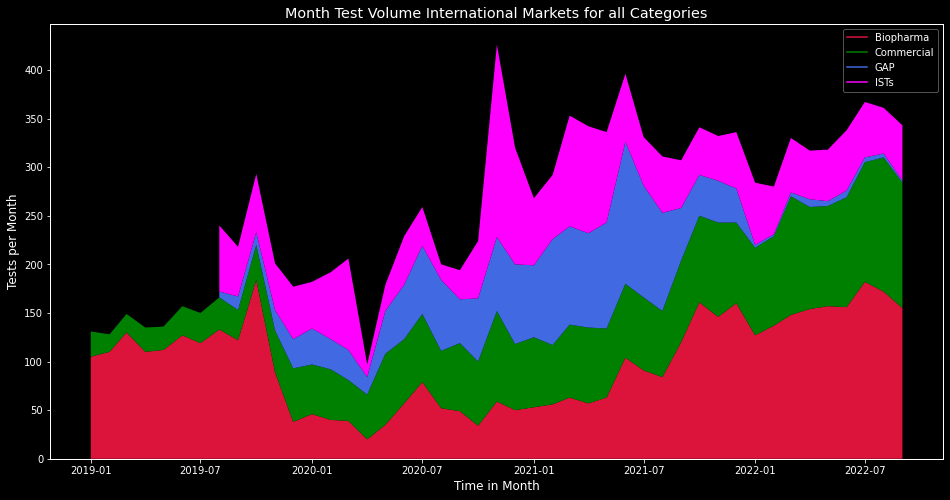

In [504]:
# Stackplot with X, Y, colors value
#plt.style.use('ggplot')
plt.subplots(figsize=(16, 8))


# Plot x-labels, y-label and data
plt.plot([], [], color ="crimson",
         label ="Biopharma")
plt.plot([], [], color ='green',
         label ='Commercial')
plt.plot([], [], color ='royalblue',
         label ='GAP')
plt.plot([], [], color ='magenta',
         label ='ISTs')


plt.stackplot(all_countries_pivot_type.index, all_countries_pivot_type["Biopharma"],
              all_countries_pivot_type["Commercial"],
              all_countries_pivot_type["GAP"],
              all_countries_pivot_type["ISTs"],
              colors =["crimson", 'green', 'royalblue', 'magenta'])
 
plt.grid(False)
plt.legend(loc='upper right')
# Days
plt.xlabel('Time in Month')
 
# No of hours
plt.ylabel('Tests per Month')
 
# Title of Graph
plt.title('Month Test Volume International Markets for all Categories')

 
# Displaying Graph


plt.savefig("test_t.pdf", transparent = True)
files.download("test_t.pdf")
plt.show()

#### Stacked area plot for Commercial, GAP and ISTS

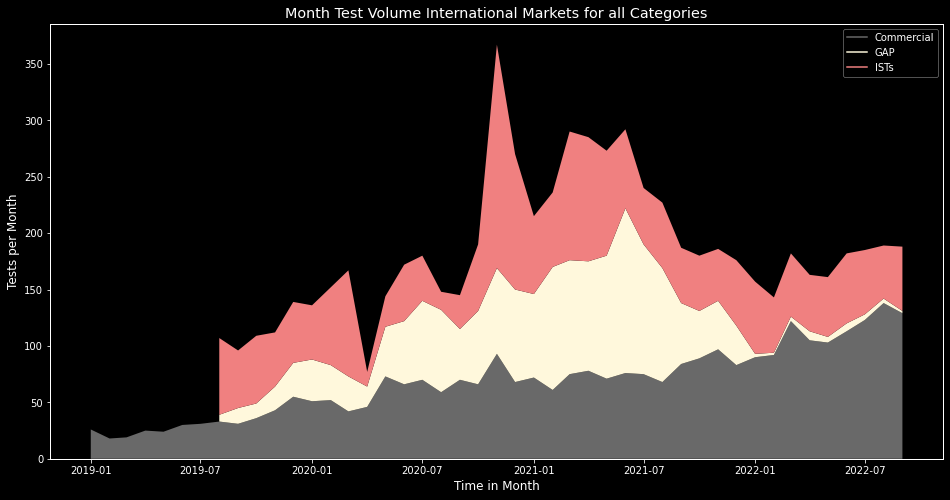

In [505]:
# Stackplot with X, Y, colors value
#plt.style.use('ggplot')
plt.subplots(figsize=(16, 8))


# Plot x-labels, y-label and data

plt.plot([], [], color ='dimgrey',
         label ='Commercial')
plt.plot([], [], color ='cornsilk',
         label ='GAP')
plt.plot([], [], color ='lightcoral',
         label ='ISTs')


plt.stackplot(all_countries_pivot_type.index,
              all_countries_pivot_type["Commercial"],
              all_countries_pivot_type["GAP"],
              all_countries_pivot_type["ISTs"],
              colors =['dimgrey', 'cornsilk', 'lightcoral'])
 
plt.grid(False)
plt.legend(loc='upper right')
# Days
plt.xlabel('Time in Month')
 
# No of hours
plt.ylabel('Tests per Month')
 
# Title of Graph
plt.title('Month Test Volume International Markets for all Categories')

 
# Displaying Graph
plt.show()

#### Plot the relative percentage of sample in each category over time

In [506]:
all_countries_pivot_type.head()

Type,Biopharma,Commercial,GAP,ISTs
Year_Month,,,,
2019-01-01,105.0,26.0,NaN,76.0
2019-02-01,110.0,18.0,NaN,69.0
2019-03-01,130.0,19.0,NaN,82.0
2019-04-01,110.0,25.0,NaN,69.0
2019-05-01,112.0,24.0,NaN,41.0


In [507]:
all_countries_pivot_type = all_countries_pivot_type.fillna(0)


In [508]:


all_countries_pivot_type["Total Sales"] = all_countries_pivot_type["Biopharma"] +all_countries_pivot_type["GAP"] + all_countries_pivot_type["Commercial"] + all_countries_pivot_type["ISTs"]

all_countries_pivot_type["Percent Commercial"] = (all_countries_pivot_type["Commercial"]/all_countries_pivot_type["Total Sales"])*100

all_countries_pivot_type["Percent Biopharma"] = (all_countries_pivot_type["Biopharma"]/all_countries_pivot_type["Total Sales"])*100

all_countries_pivot_type["Percent GAP"] = (all_countries_pivot_type["GAP"]/all_countries_pivot_type["Total Sales"])*100

all_countries_pivot_type["Percent ISTs"] = (all_countries_pivot_type["ISTs"]/all_countries_pivot_type["Total Sales"])*100


In [509]:
all_countries_pivot_type.head(2)

Type,Biopharma,Commercial,GAP,ISTs,Total Sales,Percent Commercial,Percent Biopharma,Percent GAP,Percent ISTs
Year_Month,,,,,,,,,
2019-01-01,105.0,26.0,0.0,76.0,207.0,12.56,50.72,0.0,36.71
2019-02-01,110.0,18.0,0.0,69.0,197.0,9.14,55.84,0.0,35.03


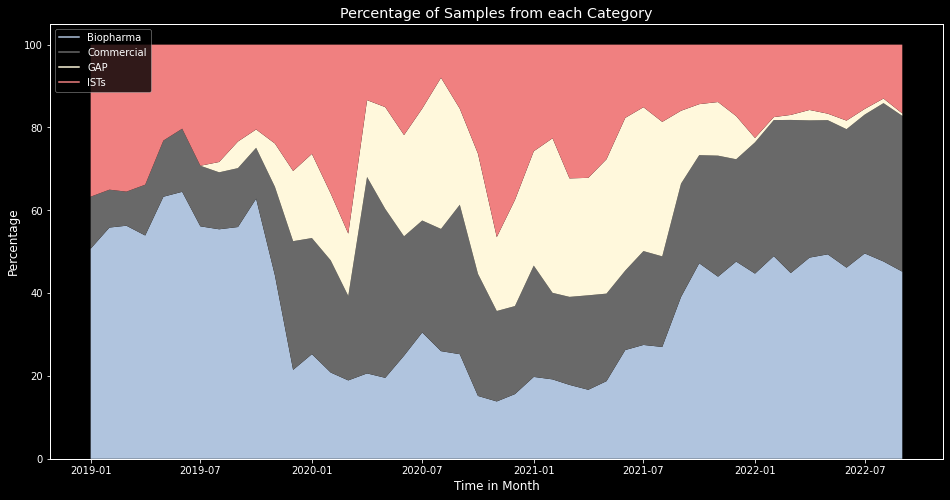

In [510]:
# Stackplot with X, Y, colors value
#plt.style.use('ggplot')
plt.subplots(figsize=(16, 8))


# Plot x-labels, y-label and data
plt.plot([], [], color ="lightsteelblue",
         label ="Biopharma")
plt.plot([], [], color ='dimgrey',
         label ='Commercial')
plt.plot([], [], color ='cornsilk',
         label ='GAP')
plt.plot([], [], color ='lightcoral',
         label ='ISTs')


plt.stackplot(all_countries_pivot_type.index, all_countries_pivot_type["Percent Biopharma"],
              all_countries_pivot_type["Percent Commercial"],
              all_countries_pivot_type["Percent GAP"],
              all_countries_pivot_type["Percent ISTs"],
              colors =["lightsteelblue", 'dimgrey', 'cornsilk', 'lightcoral'])
 
plt.grid(False)
plt.legend(loc='upper left')
# Days
plt.xlabel('Time in Month')
 
# No of hours
plt.ylabel('Percentage')
 
# Title of Graph
plt.title('Percentage of Samples from each Category')

 
# Displaying Graph
plt.show()

#### Add second y axis

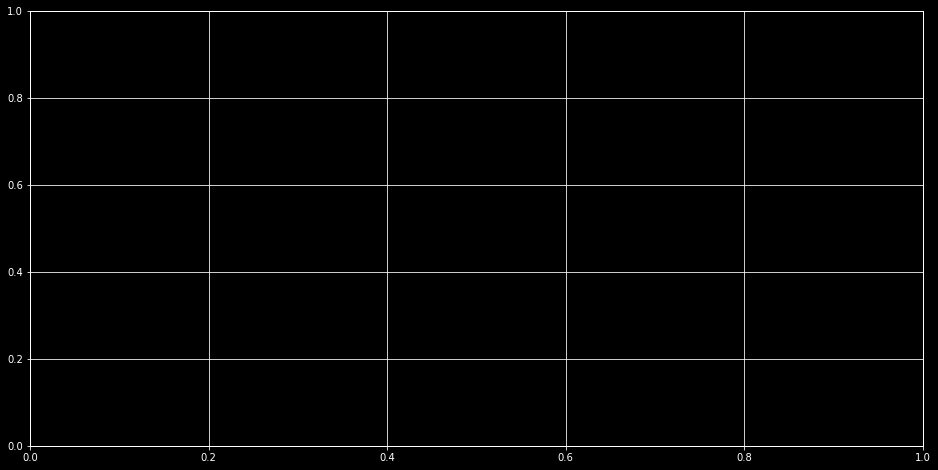

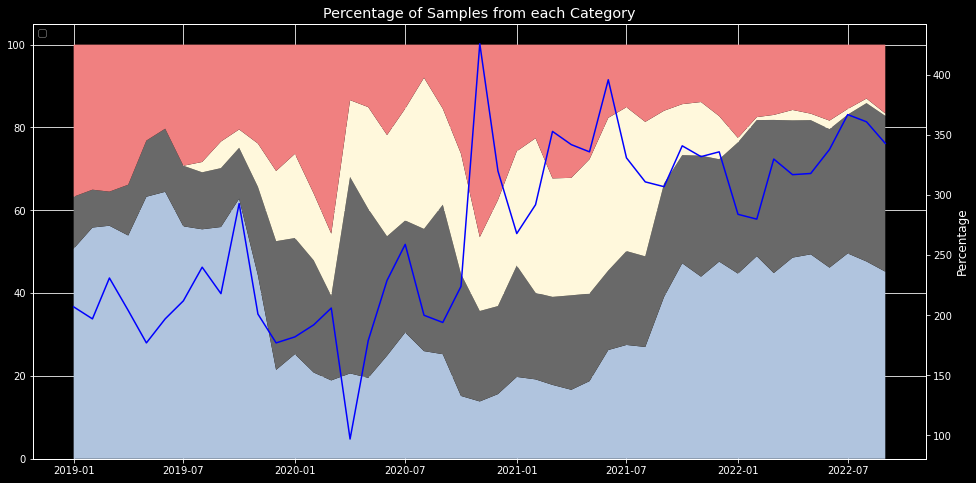

In [511]:
# Stackplot with X, Y, colors value
#plt.style.use('ggplot')
plt.subplots(figsize=(16, 8))

fig, ax = plt.subplots(1,1, figsize = (16, 8))

ax2 = ax.twinx()

# Plot x-labels, y-label and data
ax.plot([], [], color ="lightsteelblue",
         label ="Biopharma")
ax.plot([], [], color ='dimgrey',
         label ='Commercial')
ax.plot([], [], color ='cornsilk',
         label ='GAP')
ax.plot([], [], color ='lightcoral',
         label ='ISTs')


ax.stackplot(all_countries_pivot_type.index, all_countries_pivot_type["Percent Biopharma"],
              all_countries_pivot_type["Percent Commercial"],
              all_countries_pivot_type["Percent GAP"],
              all_countries_pivot_type["Percent ISTs"],
              colors =["lightsteelblue", 'dimgrey', 'cornsilk', 'lightcoral'])

ax2.plot(all_countries_pivot_type.index, all_countries_pivot_type["Total Sales"], color = 'b')
 
plt.grid(False)
plt.legend(loc='upper left')
# Days
plt.xlabel('Time in Month')
 
# No of hours
plt.ylabel('Percentage')
 
# Title of Graph
plt.title('Percentage of Samples from each Category')

 
# Displaying Graph
plt.show()

# Analysing the breakdown of commercial samples

In [512]:
#Select the time horizion to analyse
start_date_com = "2020"
end_date_com = "2022-09"
#Select the # of countries to be analyses based on the maxiumum number of samplesin 
#the time horizon
num_countries = 6
#Create the dataframe relevant for the time periode which should be analysed
df_merged_time_horizon = df_merged.loc[start_date:end_date].copy()
print(f"The total number of samples in this dataframe is {df_merged_time_horizon.shape[0]}")

The total number of samples in this dataframe is 5


In [513]:
#identiy the top commercial countries
df_merged_time_horizon["FOC"] = df_merged_time_horizon["FOC"].astype("string")

#Create the dataframe relevant for the time periode which should be analysed

print(f"The total number of samples in this dataframe is {df_merged_time_horizon.shape[0]}")


The total number of samples in this dataframe is 5


In [514]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3533 entries, 0 to 3532
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Accession #            3533 non-null   object        
 1   Reporting Country      3533 non-null   object        
 2   Billing Type           3533 non-null   object        
 3   LIMS Project ID        3533 non-null   object        
 4   Account: Account Name  3533 non-null   object        
 5   Contact: Full Name     3533 non-null   object        
 6   Final Report Date      3530 non-null   object        
 7   Test Type              3533 non-null   object        
 8   Cancer Type            1182 non-null   object        
 9   Type                   3533 non-null   category      
 10  Month                  3533 non-null   int64         
 11  Year                   3533 non-null   int64         
 12  Quarter                3533 non-null   int64         
 13  Sal

In [515]:
#Create a dataframe with just the topx countries by number of tests sold
top_comm_x = df_merged.groupby('Reporting Country').sum().sort_values("Sales",ascending = False).head(num_countries)
top_comm_x_list = top_comm_x.index.tolist()
top_comm_x_sales =df_merged[df_merged['Reporting Country'].isin(top_comm_x_list)]
print(f"The top 5 countries have {top_comm_x_sales.shape[0]} samples which represents {top_comm_x_sales.shape[0]/df_merged.shape[0]:.2%}")

The top 5 countries have 3154 samples which represents 89.27%


In [516]:
top_comm_x_list

['UNITED KINGDOM', 'SPAIN', 'BRAZIL', 'TURKEY', 'CANADA', 'IRELAND']

In [517]:
#merged_top_x_countries = df_merged[df_merged['Reporting Country'].isin(top_comm_x_list)]
#merged_top_x_countries["Reporting Country"].value_counts()

In [518]:
list_for_FOC_analysis = [
 'Reporting Country',
 'Type',
 'Sales', 'FOC',
 'Year_Month']

In [519]:
commercial_sales_FOC_analysis_df = top_comm_x_sales[list_for_FOC_analysis]
commercial_sales_FOC_analysis_df["FOC"] = commercial_sales_FOC_analysis_df["FOC"].astype("category")
commercial_sales_FOC_analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3154 entries, 0 to 3532
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Reporting Country  3154 non-null   object        
 1   Type               3154 non-null   category      
 2   Sales              3154 non-null   int64         
 3   FOC                3154 non-null   category      
 4   Year_Month         3154 non-null   datetime64[ns]
dtypes: category(2), datetime64[ns](1), int64(1), object(1)
memory usage: 105.1+ KB


In [520]:
commercial_sales_FOC_analysis_df["FOC"].value_counts()

Paid    2565
Free     588
           1
Name: FOC, dtype: int64

In [521]:
FOC_df = commercial_sales_FOC_analysis_df.groupby(['Year_Month','Reporting Country', "FOC"]).sum().reset_index()
FOC_df.tail()


,Year_Month,Reporting Country,FOC,Sales
661,2022-09-01,TURKEY,Free,0
662,2022-09-01,TURKEY,Paid,14
663,2022-09-01,UNITED KINGDOM,,0
664,2022-09-01,UNITED KINGDOM,Free,18
665,2022-09-01,UNITED KINGDOM,Paid,57


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

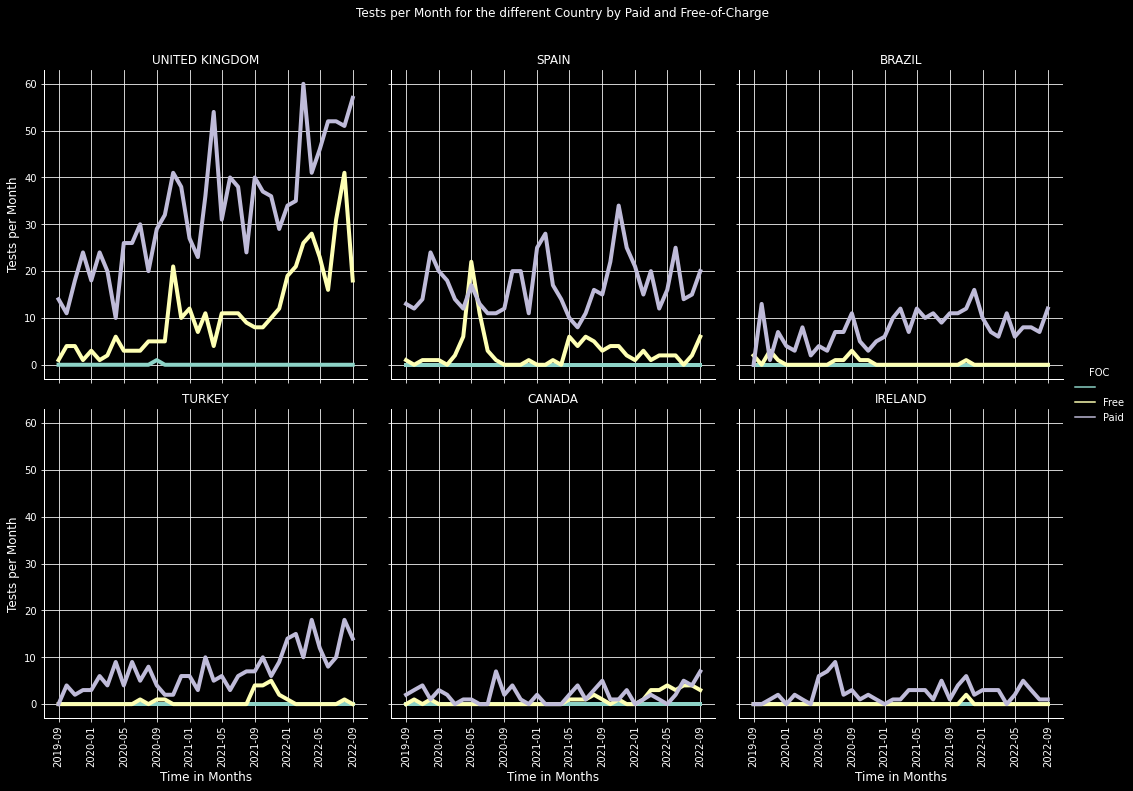

In [522]:
#Plot the sales for each category over time
g = sns.relplot(data = FOC_df, x = "Year_Month", y = "Sales", kind = "line", hue = "FOC", col = "Reporting Country", color = "#7851a9", linewidth=4 , ci = None, col_wrap = 3,
                col_order = ['UNITED KINGDOM', 'SPAIN', 'BRAZIL', 'TURKEY', 'CANADA', 'IRELAND'])
g.set_xticklabels(rotation = "90")

g.set_ylabels("Tests per Month")
g.set_xlabels("Time in Months")
g.set_titles(col_template = '{col_name}')
g.fig.suptitle('Tests per Month for the different Country by Paid and Free-of-Charge', y=1.05)

plt.savefig('comm.pdf', dpi = 300, bbox_inches ="tight",
            pad_inches = 1)
files.download("comm.pdf")
plt.show()


In [529]:
#Total sales
all_countries_comm = commercial_sales_FOC_analysis_df.groupby(['Year_Month', "FOC"]).sum().reset_index()
all_countries_comm.sample(3)

,Year_Month,FOC,Sales
39,2020-10-01,,0
47,2020-12-01,Paid,61
104,2022-07-01,Paid,92


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

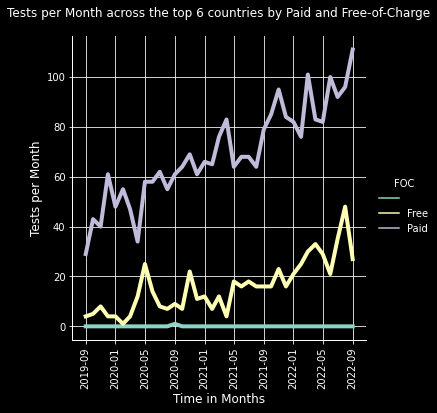

In [531]:
#Plot the sales for each category over time
g = sns.relplot(data = all_countries_comm , x = "Year_Month", y = "Sales", kind = "line", hue = "FOC",  color = "#7851a9", linewidth=4 , ci = None)
g.set_xticklabels(rotation = "90")

g.set_ylabels("Tests per Month")
g.set_xlabels("Time in Months")
g.set_titles(col_template = '{col_name}')
g.fig.suptitle('Tests per Month across the top 6 countries by Paid and Free-of-Charge', y=1.05)

plt.savefig('comm_all.pdf', dpi = 300, bbox_inches ="tight",
            pad_inches = 1)
files.download("comm_all.pdf")
plt.show()

#### Use the subplots method

In [524]:
#fig, axes = plt.subplots(2, 3, figsize=(24, 12), sharey = False)

#for col, ax in zip(col_list, axes.flatten()):
 #  sns.lineplot(data =  sandbox, x = "Year_Month", y = "Sales" , hue = "Type", ax = ax)
   #ax.plot(t.index, t[col], hue = "Type" color = "#ae34eb")
  # ax.set_title(col[1])

In [525]:
#fig, axes = plt.subplots(2, 3, figsize=(24, 12), sharey = False)

#for col, ax in zip(col_list, axes.flatten()):
   #sns.lineplot(data =  sandbox, x = "Year_Month", y = "Sales" , hue = "Type", ax = ax)
   #ax.plot(sandbox.index, sandbox[col], color = "#ae34eb")
   #ax.set_title(col[1])